# SEPP2

Recall that the "SEPP2" model is a grid-based, Hawkes-type self-excited process model.  It is a parameterised model, with the model parameters fitted using an EM algorithm.

In [1]:
%matplotlib inline
from common import *
datadir = os.path.join("//media", "disk", "Data")
#datadir = os.path.join("..", "..", "..", "..", "..", "Data")

import open_cp.logger
open_cp.logger.log_to_true_stdout()

GDAL_DATA not set and failed to find suitable location...  This is probably not a problem on linux.


In [2]:
south_side, points = load_data(datadir)
points.time_range

(numpy.datetime64('2011-03-01T00:01:00.000'),
 numpy.datetime64('2012-01-06T19:00:00.000'))

In [3]:
masked_grid = grid_for_south_side()
masked_grid2 = grid_for_south_side(xsize=100, ysize=100)

# Fit the model

We fit the model with the default grid size (250m) and a smaller grid (100m).

- The smaller grid often fails to converge, especially if edge correction is used.
- A very ad hoc justification of why this might be is that as the grid size gets smaller, because there is no interactions between different grid cells built into the model, it becomes increasingly different to tell the difference between a Poisson process and a self-exciting process, looking at just one grid cell.

In [4]:
import open_cp.seppexp as sepp

In [5]:
trainer = sepp.SEPPTrainer(masked_grid.region(), grid_size=masked_grid.xsize)
trainer.data = points
predictor = trainer.train(iterations=100, use_corrected=True)

In [19]:
trainer2 = sepp.SEPPTrainer(masked_grid2.region(), grid_size=masked_grid2.xsize)
trainer2.data = points
predictor2 = trainer2.train(iterations=100, use_corrected=False)

In [20]:
background = predictor.background_prediction()
background.mask_with(masked_grid)

background2 = predictor2.background_prediction()
background2.mask_with(masked_grid2)

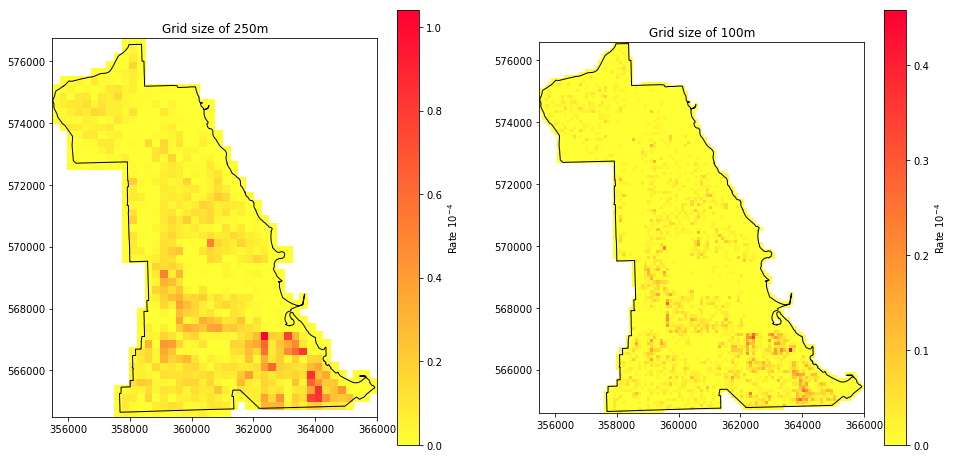

In [21]:
fig, ax  = plt.subplots(ncols=2, figsize=(16,8))

for a in ax:
    a.set_aspect(1)
    a.add_patch(descartes.PolygonPatch(south_side, fc="none", ec="Black"))
    
mappable = ax[0].pcolormesh(*background.mesh_data(), background.intensity_matrix * 10000, cmap=yellow_to_red)
ax[0].set_title("Grid size of 250m")
cbar = fig.colorbar(mappable, ax=ax[0])
cbar.set_label("Rate $10^{-4}$")

mappable = ax[1].pcolormesh(*background2.mesh_data(), background2.intensity_matrix * 10000, cmap=yellow_to_red)
ax[1].set_title("Grid size of 100m")
cbar = fig.colorbar(mappable, ax=ax[1])
cbar.set_label("Rate $10^{-4}$")

In [22]:
print("Predicted omega={}, omega^-1={}, theta={}x10^-4".format(predictor.omega,
    1/predictor.omega, predictor.theta*10000))

print("Predicted omega={}, omega^-1={}, theta={}x10^-4".format(predictor2.omega,
    1/predictor2.omega, predictor2.theta*10000))

Predicted omega=0.008291036899955296, omega^-1=120.61217578290984, theta=187.1804675740201x10^-4
Predicted omega=0.00933826759670467, omega^-1=107.08624374320613, theta=159.92031077236084x10^-4


We recall that the "aftershock kernel" has the form

$$ \theta \omega e^{-\omega \Delta t} $$

where $\Delta t$ is the time gap.

- We work in units of minutes.
- This kernel is formed by $\theta$, the overall rate, and an [exponential distribution](https://en.wikipedia.org/wiki/Exponential_distribution) with _rate_ $\omega$
- The mean of this exponential random variable is $1/\omega$.
- So the rate is high, about 190 times the maximum background rate.  But the mean is 2 hours.
- E.g. if $\Delta t$ is a day, then the rate, scaled by $10^4$, is $< 10^{-5}$, i.e. effectively zero.

In summary, the model predicts rather large aftershocks which are rather tightly localised in time.  This seems unrealistic.

For the grid size of 100m, the situation if anything gets worse, as the decay of exponential increases.

## Visualise some time series

In [11]:
def points_in(region):
    mask = (points.xcoords >= region.xmin) & (points.xcoords < region.xmax)
    mask &= (points.ycoords >= region.ymin) & (points.ycoords < region.ymax)
    return points[mask]

by_grid = {}
for x in range(masked_grid.xextent):
    for y in range(masked_grid.yextent):
        if masked_grid.is_valid(x, y):
            by_grid[(x,y)] = points_in(masked_grid.bounding_box_of_cell(x, y))

In [12]:
size_lookup = { key : tp.number_data_points for key, tp in by_grid.items() }
size_lookup = list(size_lookup.items())
size_lookup.sort(key = lambda p : p[1])
size_lookup[-5:]

[((32, 8), 38), ((34, 2), 38), ((33, 5), 39), ((34, 3), 41), ((27, 10), 51)]

In [13]:
distances = {}
for key, tp in by_grid.items():
    cell = masked_grid.bounding_box_of_cell(*key)
    midx, midy = (cell.xmin + cell.xmax)/2, (cell.ymin + cell.ymax)/2
    distances[key] = np.sqrt((tp.xcoords - midx)**2 + (tp.ycoords - midy)**2)

In the following plot, for the 5 grid cells with the highest crime count, we plot the occurance of events
- X axis is the number of minutes since the start of the study period
- Y axis is the distance of the event from the centroid of the grid cell (as expected, there is no particular pattern in this).

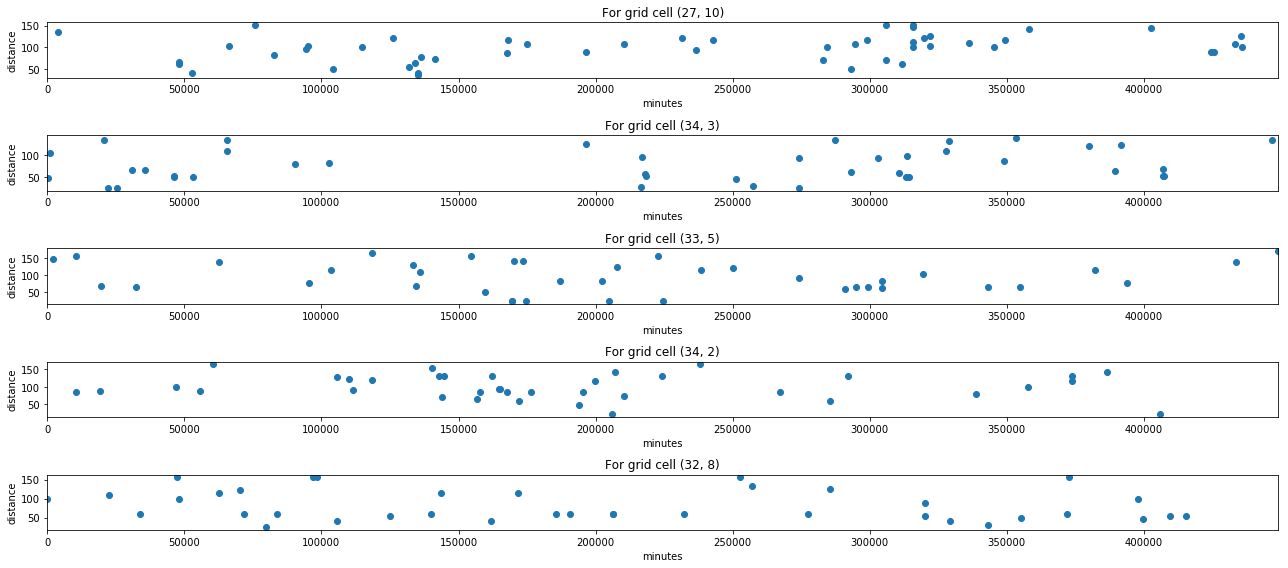

In [14]:
start = points.time_range[0]
end = points.time_range[1]
length = (end - start) / np.timedelta64(1,"m")

fig, axes = plt.subplots(nrows=5, figsize=(18,8))

for i, ax in enumerate(axes):
    key = size_lookup[-1-i][0]
    ts = (by_grid[key].timestamps - start) / np.timedelta64(1,"m")
    ax.scatter(ts, distances[key])
    ax.set(xlabel="minutes", ylabel="distance")
    ax.set(title="For grid cell {}".format(key))
    ax.set(xlim=[0,length])
    
fig.tight_layout()

## Can we tell the difference from a Poisson process?

For the cell with the most data, we apply the following procedure:

- Transform the timeseries into "minutes since start of study"
- Pretend that the data is from a homogeneous Poisson process, and estimate the rate
- Use the "compensator" to transform the timeseries into what should be a unit-rate Poisson process
- Compute the waiting times, which should give IID samples from a unit rate exponential distribution
- Produce a [Q-Q plot](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot) against the theoretical quartiles of a unit rate exponential.
- Transform to a $U[0,1]$ uniform random variable and plot $u_{i+1}$ against $u_i$ as a visual inspect of autocorrelation.
- Do the same for an actual sample from a unit rate exponential distribution

Conclusion: Little visually to say that we don't just have a Poisson process!

In [15]:
key = size_lookup[-1][0]
ts = by_grid[key].timestamps

ts = (np.asarray(ts) - start) / np.timedelta64(1,"m")
rate = len(ts) / length

def comp(t):
    return rate * t

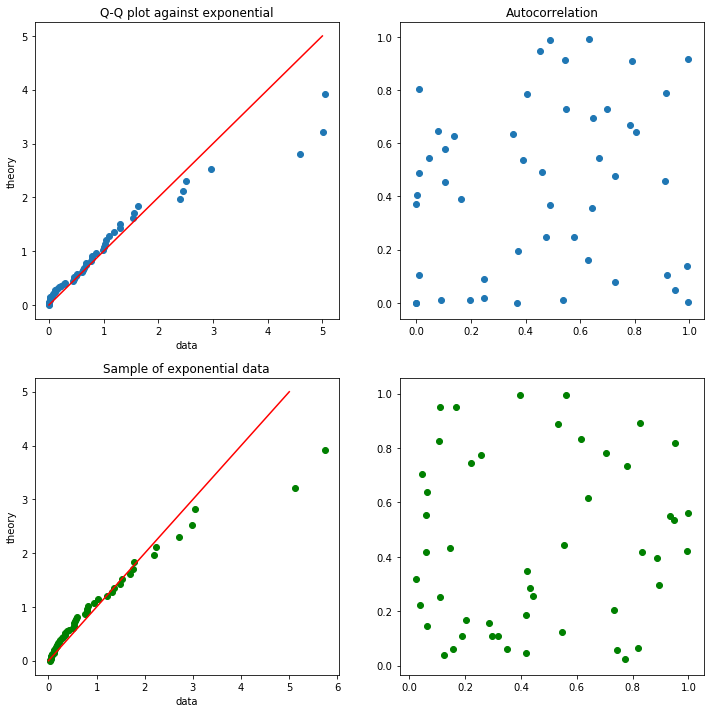

In [16]:
def qq_data(a, b, ax):
    a, b = np.array(a), np.array(b)
    a.sort()
    b.sort()
    ax.scatter(a, b)

def qq_exponential(a, ax, **kwargs):
    a = np.array(a)
    a.sort()
    b = []
    for i, x in enumerate(a):
        p = i / len(a)
        b.append( -np.log(1-p) )
    ax.scatter(a, b, **kwargs)
    ax.set(xlabel="data", ylabel="theory")
    
def correlate(a, ax, **kwargs):
    # To uniform dist
    u = 1 - np.exp(-a)
    ax.scatter(u[:-1], u[1:], **kwargs)

diffs = comp(ts)
diffs = diffs[1:] - diffs[:-1]

def do_test_plots(diffs, alpha=1):
    expected = np.random.exponential(size=len(diffs))

    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 12))
    ax = axes[0][0]
    qq_exponential(diffs, ax, alpha=alpha)
    ax.plot([0,5], [0,5], color="red")
    ax.set(title="Q-Q plot against exponential")

    ax = axes[0][1]
    correlate(diffs, ax, alpha=alpha)
    ax.set(title="Autocorrelation")

    ax = axes[1][0]
    qq_exponential(expected, ax, color="green", alpha=alpha)
    ax.plot([0,5], [0,5], color="red")
    ax.set(title="Sample of exponential data")

    ax = axes[1][1]
    correlate(expected, ax, color="green", alpha=alpha)

do_test_plots(diffs)

For each cell, do the same, combine, and plot.

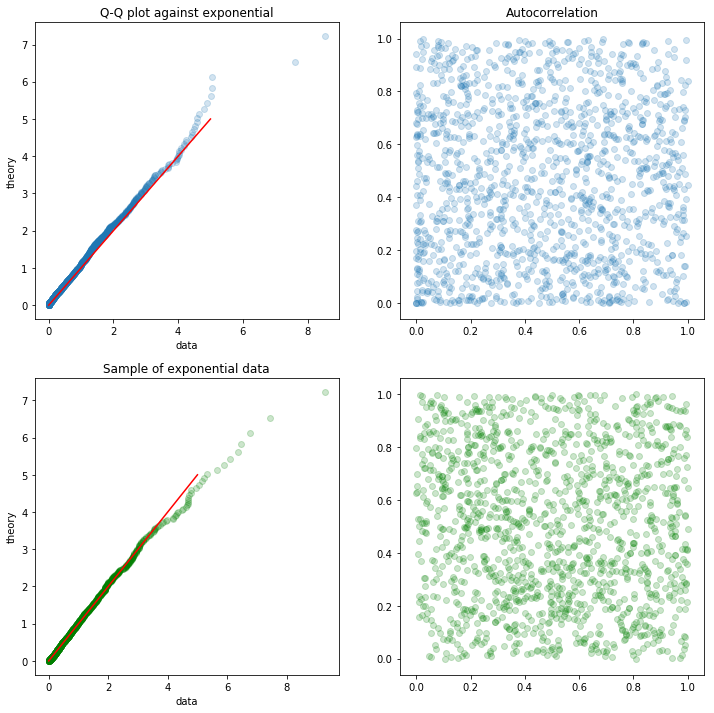

In [17]:
diffs = []
for key, tp in by_grid.items():
    ts = tp.timestamps
    if len(ts) < 10:
        continue
    ts = (np.asarray(ts) - start) / np.timedelta64(1,"m")
    rate = len(ts) / length
    ts *= rate
    
    d = ts[1:] - ts[:-1]
    diffs.extend(d)

diffs = np.asarray(diffs)
do_test_plots(diffs, alpha=0.2)

In [18]:
diffs

array([ 0.88088752,  0.23698213,  1.22473434, ...,  0.37605322,
        0.38567505,  0.13310199])